In [1]:
%load_ext autoreload
%autoreload 2

import strat_models

import numpy as np
import pandas as pd
import cvxpy as cp
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from utils import backtest, annualized_return_risk, get_wts_cm_cc, get_wts_cm_sc

np.random.seed(0)

In [2]:
#Load data
nbins = 50
K = (nbins)**2
sectors = ['XLB', 'XLV', 'XLP', 'XLY', 'XLE', 'XLF', 'XLI', 'XLK', 'XLU']

df = pd.read_csv("data/sectors_data.csv", index_col="Unnamed: 0")

#Holdout for application
holdout_date = "2018-01-01"
df_heldout = df[holdout_date:]
df = df[:holdout_date]

df

,XLB,XLV,XLP,XLY,XLE,XLF,XLI,XLK,XLU,VIX_quantile_yesterday,5_day_trail_vol_yesterday
2000-01-11,-1.1993,-1.7912,0.0000,-0.5653,0.1122,-1.6575,-1.2766,-2.6099,-1.0765,40.0,1.0
2000-01-12,-1.4451,-1.6618,0.5246,-0.5685,-0.4484,1.9663,-1.1853,-0.4253,-1.0309,39.0,1.0
2000-01-13,0.4106,1.6868,0.5219,0.5198,1.7455,2.5180,1.9084,0.9152,-0.9259,38.0,1.0
2000-01-14,-0.7009,-0.8687,0.3245,-0.2585,-0.6087,2.3396,-0.6956,2.2975,0.8178,37.0,1.0
2000-01-18,-2.4118,-1.7912,-1.4277,-0.5702,1.2249,-2.6210,-0.1078,0.5319,-0.4056,35.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.3826,-0.3246,0.1585,-0.1916,0.2089,-0.2844,0.0265,-0.0619,0.1528,0.0,25.0
2017-12-26,-0.0829,0.0241,0.2286,0.2223,0.8754,-0.2852,0.1061,-0.6663,-0.5910,0.0,22.0
2017-12-27,0.1327,0.1688,-0.0175,-0.2016,-0.3306,0.1073,0.2385,0.1092,0.4219,0.0,19.0
2017-12-28,0.4472,0.1445,-0.1579,0.2727,0.1520,0.3929,0.1982,0.1714,0.5539,0.0,18.0


In [3]:
G_vix = nx.path_graph(nbins) #vix quantiles (deciles)
G_vol = nx.path_graph(nbins) #volume quantiles

G = strat_models.cartesian_product([G_vix, G_vol])

In [4]:
#data
df_train, df_ = train_test_split(df, test_size=0.3, random_state = 10)
df_test, df_val = train_test_split(df_, test_size=0.5, random_state = 10)

def make_data_dict(df1):
    Y, Z = [], []
    yshape = []
    for vix in df1["VIX_quantile_yesterday"].unique():
        for vol in df1["5_day_trail_vol_yesterday"].unique():
            Z += [(int(vix), int(vol))]
            y = np.array(df1[(df1.VIX_quantile_yesterday == vix)&
                         (df1["5_day_trail_vol_yesterday"] == vol)][sectors]).T 

            yshape += [y.shape]
            
            if y.shape[1] == 0:
                y = y.reshape(-1,1)
            if y.shape[0] == 0:
                y = np.zeros((9,1))

            Y += [y]
    
    for node in G.nodes():
        if node not in Z:
            Y += [np.zeros((9,1))]
            Z += [node]
            
    return dict(Y=Y, Z=Z, n=9), yshape

data_train, ys = make_data_dict(df1=df_train)
ys_num = [s[1] for s in ys]
ys_zero = [idx==0 for idx in ys_num]

for idx in np.where(ys_zero)[0]:
    data_train["Y"][idx] = np.zeros((9,1))
    
print("In the training set:")
print("\tMarket conditions average of {} data points.".format(np.mean(ys_num)))
print("\tThe most populated market condition has {} data points.".format(max(ys_num)))
print("\t{} market conditions have no data.".format(len(np.where(ys_zero)[0])))
    
data_val, _ = make_data_dict(df1=df_val)
data_test, _ = make_data_dict(df1=df_test)

data_common_train = dict(Y=[np.hstack(data_train["Y"])], Z=[0], n=9)
data_common_val = dict(Y=[np.hstack(data_val["Y"])], Z=[0], n=9)
data_common_test = dict(Y=[np.hstack(data_test["Y"])], Z=[0], n=9)

In the training set:
	Market conditions average of 1.2664 data points.
	The most populated market condition has 38 data points.
	1395 market conditions have no data.


In [5]:
# #common model
theta_common = cp.Variable((9,9), PSD=True)

train_common = []
for y in data_train["Y"]:
    if np.sum(abs(y)) > 1e-7:
        train_common += [y]
        
train_common = np.hstack(train_common)

N = train_common.shape[1]
Y = train_common@train_common.T/N
local = cp.Parameter(nonneg=True)
obj = cp.trace(Y@theta_common) - cp.log_det(theta_common) + 5*cp.trace(theta_common)
prob = cp.Problem(cp.Minimize(obj))

prob.solve(verbose=False)
logprobs = []
for y, z in zip(data_test["Y"], data_test["Z"]):
    n, nk = y.shape
    Y = (y@y.T)/nk
    if (np.zeros((n,n)) == Y).all():
        continue
    logprobs = [np.linalg.slogdet(theta_common.value)[1] - np.trace(Y@theta_common.value)]

test_ANLL = -np.mean(np.array(logprobs))/np.hstack(data_test["Y"]).shape[1]
print("Common model:")
print("\t", test_ANLL)

Common model:
	 0.006359796271096148


In [6]:
#common model risk
w = np.ones(9)/9
Sigma_common = np.linalg.inv(theta_common.value)
risk_common = np.sqrt(w@Sigma_common@w)
print("Common risk =", risk_common)

Common risk = 1.1324342386731268


In [7]:
"""STRATIFIED MODEL"""

kwargs = dict(verbose=True, abs_tol=1e-6, maxiter=1000, rho=10)

local = .15

G_vix = nx.path_graph(nbins) #vix quantiles (deciles)
G_vol = nx.path_graph(nbins) #volume quantiles

wt_vix = 1500
wt_vol = 2500

loss = strat_models.covariance_max_likelihood_loss()
reg = strat_models.trace_reg(lambd=local)

print("local, vix, spy, vol =", local, wt_vix, wt_vol)

strat_models.set_edge_weight(G_vix, wt_vix)
# strat_models.set_edge_weight(G_spy, wt_spy)
strat_models.set_edge_weight(G_vol, wt_vol)

G = strat_models.cartesian_product([G_vix, G_vol])

bm = strat_models.BaseModel(loss=loss,reg=reg)
sm = strat_models.StratifiedModel(BaseModel=bm, graph=G)

sm.fit(data=data_train, **kwargs)

test_ANLL = sm.anll(data_test)/np.hstack(data_test["Y"]).shape[1]
print("Stratified model:")
print("\t", test_ANLL)

inv_covs = dict()
covs = dict()

for node in sm.G.nodes():
    covs[node] = np.linalg.inv(sm.G._node[node]["theta"].copy()).copy()

local, vix, spy, vol = 0.15 1500 2500
 it |     s_norm     r_norm    eps_pri   eps_dual    rho  time1  time2  time3
  1 | 4.5139e+01 3.5030e+02 3.5094e-01 4.5202e-01 10.000 162.959 10.857 111.200
  2 | 2.0442e+01 2.6600e+02 2.6664e-01 5.6294e-01 10.000 193.319 14.935 110.024
  3 | 3.7796e+01 5.5365e+01 5.6002e-02 6.0022e-01 5.000 186.633 12.493 110.732
  4 | 1.3200e+01 6.9149e+01 6.9786e-02 6.3294e-01 5.000 177.081 13.343 111.327
  5 | 1.1694e+01 4.8668e+01 4.9304e-02 6.4385e-01 5.000 187.120 12.477 110.654
  6 | 1.2216e+01 5.9090e+01 5.9726e-02 6.4028e-01 5.000 181.879 12.498 110.755
  7 | 1.1405e+01 4.2392e+01 4.3029e-02 6.3115e-01 5.000 187.579 16.694 113.949
  8 | 1.1667e+01 4.9095e+01 4.9731e-02 6.1951e-01 5.000 180.796 12.550 106.404
  9 | 1.0799e+01 3.6765e+01 3.7401e-02 6.0828e-01 5.000 176.062 12.538 108.027
 10 | 1.0399e+01 4.0974e+01 4.1611e-02 5.9907e-01 5.000 180.507 12.714 105.729
 11 | 9.7547e+00 3.2431e+01 3.3068e-02 5.9146e-01 5.000 170.482 12.481 106.792
 12 | 9.0420e

104 | 1.0928e+00 6.4007e+00 7.0371e-03 6.7298e-01 5.000 165.678 12.250 106.751
105 | 1.0948e+00 6.3764e+00 7.0128e-03 6.7327e-01 5.000 164.094 12.474 108.316
106 | 1.0752e+00 6.3053e+00 6.9417e-03 6.7361e-01 5.000 163.739 11.955 106.033
107 | 1.0771e+00 6.2782e+00 6.9146e-03 6.7389e-01 5.000 170.665 11.992 105.212
108 | 1.0581e+00 6.2129e+00 6.8493e-03 6.7422e-01 5.000 174.672 12.125 105.838
109 | 1.0600e+00 6.1829e+00 6.8193e-03 6.7449e-01 5.000 171.452 12.375 105.948
110 | 1.0417e+00 6.1234e+00 6.7598e-03 6.7481e-01 5.000 170.234 12.359 105.810
111 | 1.0434e+00 6.0907e+00 6.7271e-03 6.7507e-01 5.000 174.417 12.382 106.119
112 | 1.0257e+00 6.0367e+00 6.6731e-03 6.7539e-01 5.000 173.444 12.409 106.173
113 | 1.0273e+00 6.0012e+00 6.6376e-03 6.7564e-01 5.000 176.192 11.901 105.626
114 | 1.0102e+00 5.9527e+00 6.5891e-03 6.7595e-01 5.000 172.411 12.325 105.826
115 | 1.0117e+00 5.9145e+00 6.5509e-03 6.7619e-01 5.000 175.252 12.633 105.656
116 | 9.9525e-01 5.8713e+00 6.5077e-03 6.7649e-01 5.

208 | 6.0939e-01 3.7533e+00 4.3897e-03 6.9095e-01 5.000 173.498 12.270 106.132
209 | 6.0665e-01 3.5453e+00 4.1817e-03 6.9103e-01 5.000 165.657 12.311 106.085
210 | 6.0385e-01 3.7161e+00 4.3525e-03 6.9112e-01 5.000 164.529 12.238 106.440
211 | 6.0197e-01 3.5193e+00 4.1557e-03 6.9120e-01 5.000 184.878 12.297 107.549
212 | 5.9923e-01 3.6800e+00 4.3164e-03 6.9129e-01 5.000 173.390 12.273 106.179
213 | 5.9745e-01 3.4880e+00 4.1244e-03 6.9136e-01 5.000 168.371 12.274 106.101
214 | 5.9388e-01 3.6351e+00 4.2715e-03 6.9145e-01 5.000 175.970 12.400 105.955
215 | 5.9375e-01 3.4186e+00 4.0550e-03 6.9152e-01 5.000 168.042 12.374 106.830
216 | 5.8618e-01 3.5381e+00 4.1745e-03 6.9161e-01 5.000 172.637 12.207 105.813
217 | 5.8511e-01 3.3279e+00 3.9643e-03 6.9168e-01 5.000 176.281 11.930 105.708
218 | 5.8044e-01 3.4733e+00 4.1097e-03 6.9176e-01 5.000 167.451 12.276 106.657
219 | 5.7716e-01 3.2983e+00 3.9347e-03 6.9183e-01 5.000 250.821 12.429 123.950
220 | 5.7338e-01 3.4316e+00 4.0680e-03 6.9191e-01 5.

312 | 4.0278e-01 2.4360e+00 3.0724e-03 6.9641e-01 5.000 175.527 12.412 105.741
313 | 4.0120e-01 2.3251e+00 2.9615e-03 6.9643e-01 5.000 173.227 11.996 105.525
314 | 4.0043e-01 2.4300e+00 3.0663e-03 6.9647e-01 5.000 169.867 12.328 105.696
315 | 3.9888e-01 2.3146e+00 2.9510e-03 6.9649e-01 5.000 171.064 12.449 105.909
316 | 3.9818e-01 2.4239e+00 3.0603e-03 6.9653e-01 5.000 174.230 12.559 105.618
317 | 3.9651e-01 2.3056e+00 2.9419e-03 6.9656e-01 5.000 190.286 12.572 107.538
318 | 3.9600e-01 2.4201e+00 3.0565e-03 6.9659e-01 5.000 170.789 12.447 106.027
319 | 3.9427e-01 2.2994e+00 2.9358e-03 6.9662e-01 5.000 229.477 12.459 110.722
320 | 3.9392e-01 2.4181e+00 3.0545e-03 6.9666e-01 5.000 208.241 11.955 109.478
321 | 3.9216e-01 2.2948e+00 2.9312e-03 6.9668e-01 5.000 173.051 12.288 105.700
322 | 3.9196e-01 2.4176e+00 3.0540e-03 6.9672e-01 5.000 172.888 12.526 106.638
323 | 3.9018e-01 2.2913e+00 2.9277e-03 6.9674e-01 5.000 175.511 12.371 111.268
324 | 3.9012e-01 2.4189e+00 3.0553e-03 6.9678e-01 5.

416 | 2.8753e-01 1.7458e+00 2.3822e-03 6.9867e-01 5.000 180.076 12.196 105.773
417 | 2.8628e-01 1.6464e+00 2.2828e-03 6.9868e-01 5.000 172.755 13.398 106.534
418 | 2.8550e-01 1.7327e+00 2.3691e-03 6.9870e-01 5.000 174.652 13.007 105.378
419 | 2.8449e-01 1.6387e+00 2.2751e-03 6.9870e-01 5.000 179.431 12.427 105.861
420 | 2.8386e-01 1.7225e+00 2.3589e-03 6.9872e-01 5.000 174.757 12.457 105.397
421 | 2.8280e-01 1.6318e+00 2.2682e-03 6.9873e-01 5.000 174.355 12.553 109.610
422 | 2.8216e-01 1.7132e+00 2.3496e-03 6.9875e-01 5.000 179.592 12.155 105.991
423 | 2.8125e-01 1.6240e+00 2.2604e-03 6.9875e-01 5.000 170.978 12.443 105.708
424 | 2.8064e-01 1.7051e+00 2.3415e-03 6.9877e-01 5.000 179.754 12.928 105.404
425 | 2.7968e-01 1.6170e+00 2.2534e-03 6.9878e-01 5.000 167.007 12.394 106.396
426 | 2.7919e-01 1.6997e+00 2.3361e-03 6.9879e-01 5.000 176.031 12.370 105.618
427 | 2.7820e-01 1.6131e+00 2.2495e-03 6.9880e-01 5.000 166.490 12.276 105.804
428 | 2.7784e-01 1.6965e+00 2.3329e-03 6.9882e-01 5.

520 | 2.1566e-01 1.3153e+00 1.9517e-03 6.9980e-01 5.000 174.906 12.314 106.529
521 | 2.1480e-01 1.2408e+00 1.8772e-03 6.9980e-01 5.000 188.015 12.001 106.431
522 | 2.1447e-01 1.3108e+00 1.9472e-03 6.9981e-01 5.000 184.873 12.605 106.061
523 | 2.1377e-01 1.2381e+00 1.8745e-03 6.9982e-01 5.000 169.577 12.395 107.104
524 | 2.1331e-01 1.3050e+00 1.9414e-03 6.9983e-01 5.000 173.787 12.058 105.787
525 | 2.1286e-01 1.2291e+00 1.8655e-03 6.9984e-01 5.000 217.664 13.513 112.789
526 | 2.1196e-01 1.2933e+00 1.9297e-03 6.9985e-01 5.000 243.330 12.172 105.003
527 | 2.1144e-01 1.2175e+00 1.8539e-03 6.9985e-01 5.000 168.492 12.220 106.808
528 | 2.1094e-01 1.2853e+00 1.9216e-03 6.9987e-01 5.000 186.443 12.337 107.765
529 | 2.1015e-01 1.2139e+00 1.8503e-03 6.9987e-01 5.000 178.046 12.526 108.704
530 | 2.0981e-01 1.2808e+00 1.9172e-03 6.9988e-01 5.000 195.863 12.936 104.798
531 | 2.0916e-01 1.2125e+00 1.8489e-03 6.9989e-01 5.000 228.322 11.836 106.118
532 | 2.0889e-01 1.2779e+00 1.9143e-03 6.9990e-01 5.

624 | 1.6828e-01 1.0223e+00 1.6587e-03 7.0051e-01 5.000 207.007 12.067 110.611
625 | 1.6767e-01 9.6098e-01 1.5974e-03 7.0051e-01 5.000 215.754 12.310 107.810
626 | 1.6741e-01 1.0188e+00 1.6552e-03 7.0052e-01 5.000 190.337 12.278 105.262
627 | 1.6696e-01 9.5930e-01 1.5957e-03 7.0052e-01 5.000 182.156 13.151 106.119
628 | 1.6643e-01 1.0121e+00 1.6485e-03 7.0053e-01 5.000 171.099 12.374 105.863
629 | 1.6622e-01 9.5103e-01 1.5874e-03 7.0054e-01 5.000 178.886 12.363 105.438
630 | 1.6561e-01 1.0039e+00 1.6403e-03 7.0054e-01 5.000 167.785 12.384 115.231
631 | 1.6501e-01 9.4607e-01 1.5825e-03 7.0055e-01 5.000 176.777 12.324 105.721
632 | 1.6464e-01 9.9803e-01 1.6344e-03 7.0056e-01 5.000 186.511 12.702 105.251
633 | 1.6423e-01 9.4127e-01 1.5777e-03 7.0056e-01 5.000 180.270 12.369 105.345
634 | 1.6358e-01 9.8949e-01 1.6259e-03 7.0057e-01 5.000 167.141 12.253 105.600
635 | 1.6323e-01 9.3406e-01 1.5705e-03 7.0057e-01 5.000 169.190 13.033 105.735
636 | 1.6278e-01 9.8266e-01 1.6191e-03 7.0058e-01 5.

728 | 1.3662e-01 8.5273e-01 1.4891e-03 7.0101e-01 5.000 181.816 12.399 106.272
729 | 1.3602e-01 7.8293e-01 1.4193e-03 7.0102e-01 5.000 185.512 12.691 105.534
730 | 1.3593e-01 8.4896e-01 1.4854e-03 7.0102e-01 5.000 194.378 13.405 116.829
731 | 1.3535e-01 7.8447e-01 1.4209e-03 7.0102e-01 5.000 199.487 15.480 107.827
732 | 1.3526e-01 8.4682e-01 1.4832e-03 7.0103e-01 5.000 198.906 12.907 112.142
733 | 1.3495e-01 7.8354e-01 1.4199e-03 7.0103e-01 5.000 188.826 12.283 106.240
734 | 1.3441e-01 8.4025e-01 1.4767e-03 7.0104e-01 5.000 178.515 12.944 106.875
735 | 1.3464e-01 7.7062e-01 1.4070e-03 7.0104e-01 5.000 196.793 14.539 106.174
736 | 1.3360e-01 8.2555e-01 1.4619e-03 7.0104e-01 5.000 178.328 12.675 106.948
737 | 1.3319e-01 7.5860e-01 1.3950e-03 7.0105e-01 5.000 236.405 12.505 112.310
738 | 1.3270e-01 8.1552e-01 1.4519e-03 7.0105e-01 5.000 256.754 14.709 114.224
739 | 1.3241e-01 7.5111e-01 1.3875e-03 7.0105e-01 5.000 202.925 13.616 111.088
740 | 1.3168e-01 8.0313e-01 1.4395e-03 7.0106e-01 5.

832 | 1.1058e-01 6.8450e-01 1.3209e-03 7.0137e-01 5.000 187.040 12.339 110.034
833 | 1.1035e-01 6.4098e-01 1.2774e-03 7.0138e-01 5.000 194.212 15.160 119.261
834 | 1.1037e-01 6.8540e-01 1.3218e-03 7.0138e-01 5.000 239.212 12.597 115.811
835 | 1.1030e-01 6.3677e-01 1.2732e-03 7.0138e-01 5.000 219.835 12.558 109.196
836 | 1.0986e-01 6.7980e-01 1.3162e-03 7.0139e-01 5.000 189.183 12.285 110.735
837 | 1.1016e-01 6.2280e-01 1.2592e-03 7.0139e-01 5.000 181.802 12.463 105.297
838 | 1.0920e-01 6.6673e-01 1.3031e-03 7.0139e-01 5.000 171.983 12.650 107.583
839 | 1.0892e-01 6.1231e-01 1.2487e-03 7.0139e-01 5.000 176.709 12.367 105.601
840 | 1.0869e-01 6.6047e-01 1.2969e-03 7.0140e-01 5.000 168.996 12.327 105.752
841 | 1.0823e-01 6.1163e-01 1.2480e-03 7.0140e-01 5.000 203.022 13.068 111.517
842 | 1.0811e-01 6.5787e-01 1.2943e-03 7.0140e-01 5.000 196.422 12.988 111.487
843 | 1.0776e-01 6.1262e-01 1.2490e-03 7.0141e-01 5.000 213.749 13.339 108.758
844 | 1.0770e-01 6.5661e-01 1.2930e-03 7.0141e-01 5.

936 | 9.0343e-02 5.4867e-01 1.1851e-03 7.0165e-01 5.000 197.226 13.771 107.024
937 | 9.0167e-02 5.2026e-01 1.1567e-03 7.0165e-01 5.000 196.612 13.065 107.587
938 | 9.0170e-02 5.5025e-01 1.1866e-03 7.0165e-01 5.000 189.432 12.487 107.182
939 | 8.9987e-02 5.2124e-01 1.1576e-03 7.0166e-01 5.000 183.160 12.965 107.514
940 | 9.0020e-02 5.5210e-01 1.1885e-03 7.0166e-01 5.000 203.460 12.212 118.190
941 | 8.9832e-02 5.2218e-01 1.1586e-03 7.0166e-01 5.000 186.474 12.202 113.243
942 | 8.9875e-02 5.5407e-01 1.1905e-03 7.0166e-01 5.000 202.817 13.184 110.046
943 | 8.9698e-02 5.2266e-01 1.1591e-03 7.0167e-01 5.000 211.363 12.166 107.280
944 | 8.9686e-02 5.5512e-01 1.1915e-03 7.0167e-01 5.000 195.347 13.560 108.486
945 | 8.9650e-02 5.1947e-01 1.1559e-03 7.0167e-01 5.000 186.482 12.371 106.486
946 | 8.9107e-02 5.4958e-01 1.1860e-03 7.0167e-01 5.000 180.984 12.313 118.259
947 | 8.9449e-02 5.0590e-01 1.1423e-03 7.0168e-01 5.000 184.579 12.518 106.519
948 | 8.8707e-02 5.3885e-01 1.1752e-03 7.0168e-01 5.

In [8]:


SPY = pd.read_csv("data/SPY.csv", parse_dates=["caldt"])
SPY_value = 1
SPY_vals = [SPY_value]
SPY_RETURNS = np.array(SPY[(SPY.caldt > holdout_date)&(SPY.caldt < "2019-01-01")]["sprtrn"])

for date in range(1,df_heldout.shape[0]):
    SPY_value *= (1+SPY_RETURNS[date])
    SPY_vals += [SPY_value]

In [9]:
"""
GENERATE STRATIFIED MARKOWITZ MV PORTFOLIOS
COMMON MEAN, STRATIFIED COVARIANCE
"""

ys_train = []
for y in data_train["Y"]:
    if not np.allclose(y, np.zeros((9,1))):
        ys_train += [y]
mu_common = np.median(np.hstack(ys_train), axis=1)

ws_sm = get_wts_cm_sc(gamma=0.15, mu=mu_common, covs=covs)

"""
GENERATE COMMON MARKOWITZ MV PORTFOLIO
COMMON MEAN, COMMON COVARIANCE
"""

ws_common = get_wts_cm_cc(gamma=0.15, mu=mu_common, cov=np.linalg.inv(theta_common.value), nodes=covs.keys())

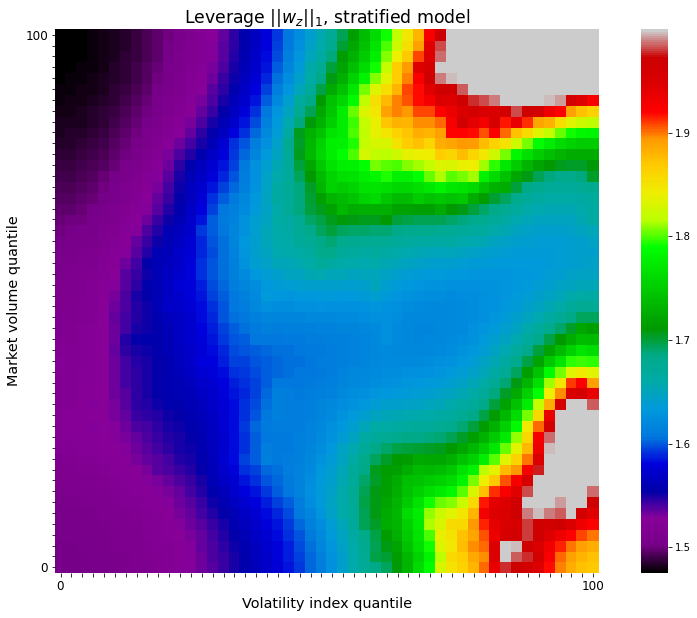

In [10]:
leverage = np.nan * np.ones((50,50))
for node in sm.G.nodes():
    leverage[node] = np.linalg.norm(ws_sm[node],1)

lx = [""]*nbins
lx[0] = 0
lx[-1] = 100

ly = [""]*nbins
ly[0] = 0
ly[-1] = 100
    
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(leverage.T, cmap="nipy_spectral", cbar=True, ax=ax)
ax.set_title("Leverage $||w_z||_1$, stratified model", fontsize="xx-large")
ax.set_ylabel("Market volume quantile", fontsize="x-large")
ax.set_xlabel("Volatility index quantile", fontsize="x-large")
ax.set_xticklabels(labels=lx, fontsize="large")
ax.set_yticklabels(labels=ly, fontsize="large")
ax.set_aspect(1.0)
ax.invert_yaxis()
plt.show()

In [11]:
RETURNS = np.array(df_heldout[sectors])/100

value_common = 1
vals_common = [value_common]
risk_common = []

value_strat = 1
vals_strat = [value_strat]
risk_strat = []

SPY = pd.read_csv("data/SPY.csv", parse_dates=["caldt"])

SPY_value = 1
SPY_vals = [SPY_value]
SPY_RETURNS = np.array(SPY[(SPY.caldt > holdout_date)&(SPY.caldt < "2019-01-01")]["sprtrn"])

lev = []
lev_common = []

W, Wcommon = [], []

for date in range(1,df_heldout.shape[0]):
    vix = int(df_heldout.iloc[date]["VIX_quantile_yesterday"])
    vol = int(df_heldout.iloc[date]["5_day_trail_vol_yesterday"])
        
    w = ws_sm[vix, vol]
        
    value_strat *= (1+RETURNS[date, :])@w
    vals_strat += [value_strat]
    lev += [np.linalg.norm(w,1)]
    W += [w.reshape(-1,1)]
        
    risk_strat += [np.sqrt(w@covs[vix,vol]@w)]
    
    w_common = ws_common[vix,vol]
    value_common *= (1+RETURNS[date, :])@w_common
    vals_common += [value_common]
    lev_common += [np.linalg.norm(w_common,1)]
    Wcommon += [w_common.reshape(-1,1)]
    risk_common += [np.sqrt(w_common@np.linalg.inv(theta_common.value)@w_common)]

    SPY_value *= (1+SPY_RETURNS[date])
    SPY_vals += [SPY_value]

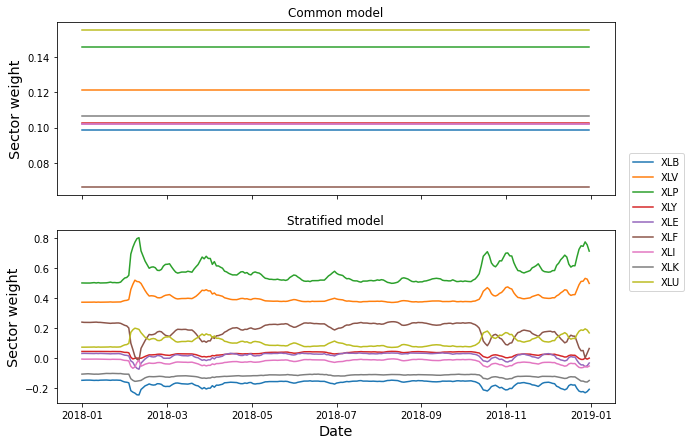

In [12]:
fig, ax = plt.subplots(2,1,figsize=(10,7), sharex=True)

models = ["Common model", "Stratified model"]
for i,w in enumerate([Wcommon, W]):
    
    for j in range(9):
        ax[i].plot(np.hstack(w).T[:,j], label=sectors[j])
    
    ax[i].set_title(models[i])
    ax[i].set_ylabel("Sector weight", fontsize="x-large")

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
ax[-1].set_xlabel("Date", fontsize="x-large")
ax[-1].set_xticks(np.linspace(0,250,7))
ax[-1].set_xticklabels(labels=["2018-01", "2018-03", "2018-05", "2018-07", "2018-09", "2018-11", "2019-01"])
plt.show()

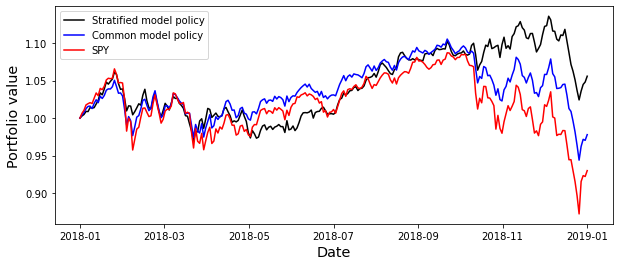

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(vals_strat, label="Stratified model policy", color="black")
ax.plot(vals_common, label="Common model policy", color="blue")
ax.plot(SPY_vals, label="SPY", color="red")
ax.set_xlabel("Date", fontsize="x-large")
ax.set_ylabel("Portfolio value", fontsize="x-large")
ax.set_xlabel("Date", fontsize="x-large")
ax.set_xticks(np.linspace(0,250,7))
ax.set_xticklabels(labels=["2018-01", "2018-03", "2018-05", "2018-07", "2018-09", "2018-11", "2019-01"])
ax.legend()
plt.show()

In [14]:
"""
Compute annualized returns and risks
"""
ret_sm, risk_sm = annualized_return_risk(vals_strat)
ret_common, risk_common = annualized_return_risk(vals_common)
ret_spy, risk_spy = annualized_return_risk(SPY_vals)

print("Stratified model:")
print("\t", ret_sm, risk_sm)
print("Common model:")
print("\t", ret_common, risk_common)
print("SPY:")
print("\t", ret_spy, risk_spy)

Stratified model:
	 0.061145173604694444 0.11236493699156617
Common model:
	 -0.014862758238913303 0.12352998527997858
SPY:
	 -0.05868676800000048 0.1703014096525601
